# Quantum Sudoku Solver with Qiskit


In [9]:
# Install Qiskit if not already installed (uncomment if needed)
# !pip install qiskit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeEssexV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import Statevector
from qiskit.qasm2 import dumps, dump

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import ceil, log2


# Diffusion function

In [10]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

# Oracle function
We'll encode the constraints (unique values in rows, columns, and boxes) as quantum logic

In [11]:
## Create constraints

clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

# def XOR(qc, a, b, output):
#     qc.cx(a, output)
#     qc.cx(b, output)


def sudoku_oracle(qc, clause_list, clause_qubits, output_qubit):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1



In [12]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

# do 2 iterations
for i in range(2):
    # Apply our oracle
    sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl', fold=-1)

NameError: name 'XOR' is not defined

This section 

In [13]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Qiskit does not provide a direct API to estimate the running time of a circuit on real hardware,
# but you can estimate the execution time by summing the durations of the gates using backend properties.

def estimate_circuit_runtime(qc, backend):
    # Get backend properties (contains gate times)
    properties = backend.properties()
    gate_times = {}
    for g in properties.gates:
        gate_times[g.gate] = g.parameters[0].value if g.parameters else 0

    total_time = 0
    for inst, qargs, cargs in qc.data:
        gate = inst.name
        if gate in gate_times:
            total_time += gate_times[gate]
        else:
            # Default to 0 if gate time not found
            pass
    return total_time

# Example usage:
# backend = FakeEssexV2()
# runtime_ns = estimate_circuit_runtime(qc, backend)
# print(f"Estimated runtime: {runtime_ns} ns")

In [ ]:
transpiled_qc.draw('mpl', fold=-1)

NameError: name 'transpiled_qc' is not defined

## Simulate

In [ ]:
qasm_simulator = AerSimulator()
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())

QiskitError: 'No counts for experiment "0"'

In [14]:
# Test the 2x2 sudoku_oracle function

# Setup a simple 2x2 sudoku problem for testing
test_var_qubits = QuantumRegister(4, name='v')
test_clause_qubits = QuantumRegister(4, name='c')
test_output_qubit = QuantumRegister(1, name='out')
test_cbits = ClassicalRegister(4, name='cbits')
test_qc = QuantumCircuit(test_var_qubits, test_output_qubit, test_clause_qubits , test_cbits)

# Initialize output qubit in |->
test_qc.initialize([1, -1]/np.sqrt(2), test_output_qubit)

# Put variable qubits in superposition
test_qc.h(test_var_qubits)

state0 = Statevector(test_qc)

# Apply oracle
sudoku_oracle(test_qc, clause_list, test_clause_qubits, test_output_qubit)

state = Statevector(test_qc)


print("Bit names by index:")
for i, q in enumerate(test_qc.qubits):
    print(f"Index {i}: {q}")
# Print basis states and their amplitudes (show phase flip)
for idx, (amp, amp0) in enumerate(zip(state.data, state0.data)):
    bits = format(idx, f'0{test_qc.num_qubits}b')
    print(f"{bits} : amp {amp}, amp0 {amp0}")
    # Print only basis states with negative amplitude (flipped phase)
    if np.abs(amp) > 1e-6 and np.sign(np.real(amp)) !=  np.sign(np.real(amp0)):
        bits = format(idx, f'0{test_qc.num_qubits}b')
        print(f"{bits} : phase flipped")
        
# initialization expected to have phase change for output 0 and 1 (i.e 00000: 0.1767766952966368+0j and 10000:-0.1767766952966368+0j)
# oracle is expected to just do phase flip for all valid solution, for both 0 and 1 output state (i.e for 2 solution there will be 4 values with phase flip)
# all helper bits (ancilla) expected to have state value of 0j


NameError: name 'XOR' is not defined

# Solve with clues

In [15]:
# Define a sample 2x2 Sudoku puzzle (0 = empty)
sudoku = np.array([
    [0, 3],
    [1, 2],
])
print("Initial 2x2 Sudoku Puzzle:")
print(sudoku)

# Flatten the sudoku array to a single list (row-major order)
clues = sudoku.flatten().tolist()

def initialize(qc, var_qubits, clues):
    # Initialize variable qubits according to sudoku clues
    # For 2x2 sudoku, clues are in sudoku[0,0], sudoku[0,1], sudoku[1,0], sudoku[1,1]
    # Each cell is encoded as 2 qubits: value 1 -> 0, 2 -> 1
    for bidx, v in enumerate(clues):
        if v == 0:
            qc.h(var_qubits[bidx])
        elif v == 2:
            qc.x(var_qubits[bidx])
        # for 1 do nothing
    


Initial 2x2 Sudoku Puzzle:
[[0 3]
 [1 2]]


In [16]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
initialize(qc, var_qubits, clues)

qc.barrier()  # for visual separation

# do 2 iterations
for i in range(2):
    # Apply our oracle
    sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl', fold=-1)

NameError: name 'XOR' is not defined

In [ ]:
# Export the current quantum circuit to a QASM file for use in Qiskit Composer
with open("circuits/sudoku_2x2.qasm", "w") as f:
    dump(qc, f)
print("Circuit exported to sudoku_2x2.qasm")

Circuit exported to sudoku_2x2.qasm


In [ ]:
qasm_simulator = AerSimulator()
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()

# Get the most probable bitstring
counts = result.get_counts()
max_bitstring = max(counts, key=counts.get)

# Convert bitstring to list of ints (reverse if needed to match qubit order)
bits = [int(b) for b in max_bitstring[::-1]]

# For 2x2 sudoku, each cell is 1 bit (since only 1 or 2 allowed), but here 4 qubits for 4 cells
# Reshape to 2x2 array and add 1 to match sudoku values (1 or 2)
sudoku_solution = np.array(bits).reshape(2, 2) + 1

print("Solved Sudoku:")
print(sudoku_solution)

plot_histogram(result.get_counts())


QiskitError: 'No counts for experiment "0"'

# Sudoku 4x4

In [17]:
# adjust XOR for multi bit values

tag_list = {}

def allocate(qc, num_qbits, tag):
    if tag not in tag_list:
        reg = QuantumRegister(num_qbits, tag)
        qc.add_register(reg)
        tag_list[tag]=reg
    return tag_list[tag]

def XOR(qc, a, b, output):
    if type(a) == int and type(b) == int:
        qc.cx(a, output)
        qc.cx(b, output)
    else: # assume 2 bits per variable a & b
        t = allocate(qc, 2, 't')
        qc.cx(a[0], t[0]); qc.cx(b[0], t[0])  # t0 = a0 XOR b0
        qc.cx(a[1], t[1]); qc.cx(b[1], t[1])  # t1 = a1 XOR b1
        qc.x(t[0]); qc.x(t[1])            # now t0=1 iff low bits equal, t1=1 iff high bits equal
        qc.ccx(t[0], t[1], output)        # eq = t0 AND t1  (a==b)
        # uncompute t0 and t1 
        qc.x(t[1]); qc.x(t[0])
        qc.cx(b[1], t[1]); qc.cx(b[0], t[0])
        qc.cx(a[1], t[1]); qc.cx(a[0], t[0])
        
        



In [18]:
# Test the XOR function for 2-bit variables

# Create a test circuit
tag_list = {}

# Helper to set a and b to specific 2-bit values
def set_2bit(qc, a_val, b_val):
    # a_val, b_val: integers 0-3
    if a_val & 0b01:
        qc.x(0)
    if a_val & 0b10:
        qc.x(1)
    if b_val & 0b01:
        qc.x(2)
    if b_val & 0b10:
        qc.x(3)

# Test all combinations
results = []
for a_val in range(4):
    for b_val in range(4):
        print(f"Testing a_val={a_val}, b_val={b_val}")
        tag_list={}
        qc = QuantumCircuit(5, 1) # 2 qubits for a, 2 for b, 1 for output quantum bit, 1 classical bit for output
        set_2bit(qc, a_val, b_val)
        # Allocate output qubit
        output = 0  # Use qubit 0 as output for simplicity
        # Use XOR to compare a=[0,1], b=[2,3], output=output qubit 0
        XOR(qc, [0, 1], [2, 3], 4)
        qc.measure(4, 0)
        sim = AerSimulator()
        res = sim.run(transpile(qc, sim)).result()
        measured = int(list(res.get_counts().keys())[0])
        print(f"result={measured}")
        results.append(((a_val, b_val), measured))

# Print results
for (a_val, b_val), measured in results:
    print(f"a={a_val:02b}, b={b_val:02b} -> output={measured} (should be 1 if a==b else 0)")

Testing a_val=0, b_val=0
result=1
Testing a_val=0, b_val=1
result=0
Testing a_val=0, b_val=2
result=0
Testing a_val=0, b_val=3
result=0
Testing a_val=1, b_val=0
result=0
Testing a_val=1, b_val=1
result=1
Testing a_val=1, b_val=2
result=0
Testing a_val=1, b_val=3
result=0
Testing a_val=2, b_val=0
result=0
Testing a_val=2, b_val=1
result=0
Testing a_val=2, b_val=2
result=1
Testing a_val=2, b_val=3
result=0
Testing a_val=3, b_val=0
result=0
Testing a_val=3, b_val=1
result=0
Testing a_val=3, b_val=2
result=0
Testing a_val=3, b_val=3
result=1
a=00, b=00 -> output=1 (should be 1 if a==b else 0)
a=00, b=01 -> output=0 (should be 1 if a==b else 0)
a=00, b=10 -> output=0 (should be 1 if a==b else 0)
a=00, b=11 -> output=0 (should be 1 if a==b else 0)
a=01, b=00 -> output=0 (should be 1 if a==b else 0)
a=01, b=01 -> output=1 (should be 1 if a==b else 0)
a=01, b=10 -> output=0 (should be 1 if a==b else 0)
a=01, b=11 -> output=0 (should be 1 if a==b else 0)
a=10, b=00 -> output=0 (should be 1 if a

In [19]:
# create clause list for all rows, cols and blocks
# For 4x4 sudoku, each cell is represented by 2 qubits (so 16 variables, 32 qubits)
# We'll create clauses to ensure all cells in each row, column, and block are unique

clause_set = set()
cells = [(2*i, 2*i+1) for i in range(16)]  # 16 cells, each with 2 qubits

# Helper to add all pairs from a list to clause_set
def add_all_pairs(indices):
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            clause_set.add((indices[i], indices[j]))

# Rows
for r in range(4):
    row_cells = [4*r + c for c in range(4)]
    add_all_pairs(row_cells)

# Columns
for c in range(4):
    col_cells = [4*r + c for r in range(4)]
    add_all_pairs(col_cells)

# 2x2 Blocks
for br in range(2):
    for bc in range(2):
        block_cells = []
        for dr in range(2):
            for dc in range(2):
                block_cells.append(4*(2*br+dr) + (2*bc+dc))
        add_all_pairs(block_cells)

# Now clause_set contains all pairs of cell indices that must be different
# To use with qubits, map cell index to its 2-qubit tuple
clause_list = []
for a, b in clause_set:
    clause_list.append([cells[a], cells[b]])

print(f"clause_list {len(clause_list)}: {clause_list}")


clause_list 56: [[(6, 7), (14, 15)], [(8, 9), (12, 13)], [(24, 25), (26, 27)], [(8, 9), (24, 25)], [(10, 11), (14, 15)], [(10, 11), (26, 27)], [(0, 1), (4, 5)], [(16, 17), (18, 19)], [(0, 1), (10, 11)], [(16, 17), (24, 25)], [(18, 19), (22, 23)], [(0, 1), (16, 17)], [(22, 23), (28, 29)], [(2, 3), (6, 7)], [(2, 3), (18, 19)], [(4, 5), (28, 29)], [(26, 27), (28, 29)], [(20, 21), (30, 31)], [(12, 13), (28, 29)], [(8, 9), (10, 11)], [(10, 11), (12, 13)], [(8, 9), (16, 17)], [(24, 25), (30, 31)], [(6, 7), (12, 13)], [(10, 11), (18, 19)], [(28, 29), (30, 31)], [(6, 7), (30, 31)], [(16, 17), (22, 23)], [(0, 1), (2, 3)], [(18, 19), (20, 21)], [(2, 3), (4, 5)], [(20, 21), (22, 23)], [(0, 1), (8, 9)], [(18, 19), (26, 27)], [(2, 3), (10, 11)], [(20, 21), (28, 29)], [(4, 5), (14, 15)], [(4, 5), (20, 21)], [(12, 13), (14, 15)], [(12, 13), (20, 21)], [(14, 15), (30, 31)], [(8, 9), (14, 15)], [(24, 25), (28, 29)], [(6, 7), (22, 23)], [(0, 1), (6, 7)], [(16, 17), (20, 21)], [(18, 19), (24, 25)], [(2, 

In [20]:

def and_all_flags(qc, clause_qubits, allgood_qubit):
    """
    Compute logical AND of all clause_qubits into allgood_qubit using a binary tree of Toffolis.
    - qc: QuantumCircuit
    - clause_qubits: list or QuantumRegister of clause flag qubits
    - allgood_qubit: target qubit for the AND result
    """

    # tree_qubits: list of ancilla qubits for intermediate results (length at least len(clause_qubits)-1)
    num_tree_qubits = sum([ceil(len(clause_qubits)/(2**idx)) for idx in range(ceil(log2(len(clause_qubits)))-1)])  
    tree_qubits = allocate(qc, num_tree_qubits, 'tr')
    n = len(clause_qubits)
    if n == 1:
        qc.cx(clause_qubits[0], allgood_qubit)
        return

    # Prepare a list to hold intermediate results
    current_layer = list(clause_qubits)
    next_layer = []
    anc_idx = 0

    # Build the binary tree
    while len(current_layer) > 1:
        next_layer = []
        for i in range(0, len(current_layer), 2):
            if i+1 < len(current_layer):
                if len(current_layer) == 2:
                    # Last layer: output to allgood_qubit
                    qc.ccx(current_layer[i], current_layer[i+1], allgood_qubit)
                else:
                    qc.ccx(current_layer[i], current_layer[i+1], tree_qubits[anc_idx])
                    next_layer.append(tree_qubits[anc_idx])
                    anc_idx += 1
            else:
                # Odd number, propagate last qubit
                next_layer.append(current_layer[i])
        current_layer = next_layer

    # Uncompute ancilla tree bits (reverse the tree)
    # We need to reverse the operations in the opposite order
    # Rebuild the tree structure to know which ancilla was used at each layer
    layers = []
    n = len(clause_qubits)
    current_layer = list(clause_qubits)
    anc_idx = 0
    while len(current_layer) > 1:
        next_layer = []
        layer_ops = []
        for i in range(0, len(current_layer), 2):
            if i+1 < len(current_layer):
                if len(current_layer) == 2:
                    # Last layer: output to allgood_qubit
                    layer_ops.append((current_layer[i], current_layer[i+1], allgood_qubit))
                else:
                    layer_ops.append((current_layer[i], current_layer[i+1], tree_qubits[anc_idx]))
                    next_layer.append(tree_qubits[anc_idx])
                    anc_idx += 1
            else:
                next_layer.append(current_layer[i])
        layers.append(layer_ops)
        current_layer = next_layer

    # Uncompute in reverse order, skip the last layer (output to allgood_qubit)
    for layer_ops in reversed(layers[:-1]):
        for a, b, target in reversed(layer_ops):
            qc.ccx(a, b, target)

In [21]:
def sudoku_oracle(qc, clause_list, output_qubit):
    clause_qubits = allocate(qc, len(clause_list), 'c')
    
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    and_all_flags(qc, clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

In [22]:
def initialize(qc, var_qubits, clues):
    # For 4x4 sudoku, each cell is encoded as 2 qubits (values 1-4)
    # clues: list of 16 values (0 for empty, 1-4 for clues)
    # var_qubits: QuantumRegister of length 32 (2 qubits per cell)
    for cell_idx, v in enumerate(clues):
        q0 = var_qubits[2 * cell_idx]
        q1 = var_qubits[2 * cell_idx + 1]
        if v == 0:
            # No clue: put both qubits in superposition
            qc.h(q0)
            qc.h(q1)
        else:
            # v in 1..4, encode as binary (1->00, 2->01, 3->10, 4->11)
            bin_val = v - 1
            if bin_val & 0b01:
                qc.x(q0)
            if bin_val & 0b10:
                qc.x(q1)

In [23]:
def filter_clause_list_by_clues(clause_list, clues):
    """
    Filters clause_list to only include clauses that involve at least one free cell.
    A free cell is indicated by a clue value of 0.
    Each clause is a pair of cell indices (tuples of qubit indices).
    """
    # Map qubit indices to cell indices (for 4x4 sudoku: cell_idx = qubit_idx // 2)
    def has_free_cell(clause):
        cell_a = clause[0][0] // 2
        cell_b = clause[1][0] // 2
        return clues[cell_a] == 0 or clues[cell_b] == 0

    return [clause for clause in clause_list if has_free_cell(clause)]

In [24]:
# create clues

# Define a sample 2x2 Sudoku puzzle (0 = empty)
# Minimal clues for a unique 4x4 Sudoku solution (one possible example)
sudoku = np.array([
    [3, 1, 0, 4],
    [4, 2, 1, 3],
    [1, 3, 4, 2],
    [2, 4, 3, 1]
])

print("Initial 4x4 Sudoku Puzzle:")
print(sudoku)




Initial 4x4 Sudoku Puzzle:
[[3 1 0 4]
 [4 2 1 3]
 [1 3 4 2]
 [2 4 3 1]]


In [ ]:
# tag_list = {}


# # Flatten the sudoku array to a single list (row-major order)
# clues = sudoku.flatten().tolist()

# var_qubits = QuantumRegister(32, name='v')
# output_qubit = QuantumRegister(1, name='out')
# cbits = ClassicalRegister(32, name='cbits')
# qc = QuantumCircuit(var_qubits, output_qubit, cbits)

# # Initialize 'out0' in state |->
# qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# # Initialize qubits in state |s>
# initialize(qc, var_qubits, clues)

# qc.barrier()  # for visual separation

# # do 2 iterations
# for i in range(2):
#     # Apply our oracle
#     sudoku_oracle(qc, clause_list, output_qubit)
#     qc.barrier()  # for visual separation
#     # Apply our diffuser
#     qc.append(diffuser(4), [0,1,2,3])

# # Measure the variable qubits
# qc.measure(var_qubits, cbits)

# print("Number of qubits:", qc.num_qubits)
# print("Number of gates:", qc.size())

# # qc.draw('mpl', fold=-1)

In [ ]:
# # For a 4x4 Sudoku circuit with 200 qubits and 2745 gates, you need a simulator that supports large numbers of qubits.
# # Qiskit AerSimulator (statevector method) supports up to MAX_QUBITS_STATEVECTOR (typically 29 on most machines).
# # For 200 qubits, you need a simulator that supports "stabilizer" or "matrix product state (MPS)" methods, or a high-performance cluster.
# qasm_simulator = AerSimulator(method='stabilizer')

# # In Qiskit, use AerSimulator with the "mps" method for large circuits:
# transpiled_qc = transpile(qc, qasm_simulator)
# result = qasm_simulator.run(transpiled_qc).result()


# # Get the most probable bitstring
# counts = result.get_counts()
# max_bitstring = max(counts, key=counts.get)

# # Each cell is encoded as 2 bits (for values 1-4)
# bits = [int(b) for b in max_bitstring[::-1]]
# cell_values = []
# for i in range(16):
#     low = bits[2*i]
#     high = bits[2*i+1]
#     val = (high << 1) | low
#     cell_values.append(val + 1)  # values are 1-4

# sudoku_solution = np.array(cell_values).reshape(4, 4)

# print("Solved Sudoku:")
# print(sudoku_solution)

# plot_histogram(result.get_counts())

# optimizing 4x4 solution for less qubits

In [ ]:

## version 1: remove the binary tree
def sudoku_oracle_ver_1(qc, clause_list, output_qubit):
    clause_qubits = allocate(qc, len(clause_list), 'c')
    
    # Compute clauses
    for i, clause in enumerate(clause_list):
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        qc.x(clause_qubits[i])

    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    for i, clause in enumerate(clause_list):
        qc.x(clause_qubits[i])
        XOR(qc, clause[0], clause[1], clause_qubits[i])



# version 2: calculate the clause sequencially and accumulate results (37 qbits , 2867 gates)
def sudoku_oracle_ver_2(qc, clause_list, output_qubit):
    # Allocate a single ancilla qubit for clause checking
    clause_flag = allocate(qc, 1, 'c')[0]
    # allocate a single accumulate qbit
    acc_flag = allocate(qc, 1, 'acc')[0]
    tmp = allocate(qc, 1, 'tmp')[0]
    qc.x(acc_flag)
    # Initialize output_qubit to 1 (AND identity)
    for clause in clause_list:
        # Compute clause: clause_flag = (clause[0] == clause[1])
        XOR(qc, clause[0], clause[1], clause_flag)
        # AND with accumulated
        qc.ccx(clause_flag, acc_flag, tmp)
        # copy output bit to accumulate flag
        qc.cx(tmp, acc_flag)
        # uncompute tmp flag
        qc.ccx(acc_flag, clause_flag, tmp)
        # Uncompute clause_flag
        XOR(qc, clause[0], clause[1], clause_flag)

    # copy acc_flag to output
    qc.cx(acc_flag, output_qubit)

    # uncompute acc_flag
    



In [40]:
from qiskit.quantum_info import Statevector

# Test sudoku_oracle_ver_2 for correctness on a small example

# Setup a simple 2x1 sudoku problem for testing
test_clues = [0, 0]  # all cells free
test_clause_list = [[(0, 1), (2, 3)], [(0, 1), (4, 5)], [(0, 1), (6, 7)], [(2, 3), (4, 5)], [(2, 3), (6, 7)], [(4, 5), (6, 7)]]  # simple clauses for 2 cells

tag_list={}
# Create quantum registers and circuit
test_var_qubits = QuantumRegister(8, name='v')
test_output_qubit = QuantumRegister(1, name='out')
# test_cbits = ClassicalRegister(4, name='cbits')
test_qc = QuantumCircuit(test_var_qubits, test_output_qubit)


# Initialize output qubit in |->
test_qc.initialize([1, -1]/np.sqrt(2), test_output_qubit)

# Put variable qubits in superposition
test_qc.h(test_var_qubits)

state0 = Statevector(test_qc)


# Apply oracle_ver_2
sudoku_oracle_ver_1(test_qc, test_clause_list, test_output_qubit)

# Measure variable qubits
# Do NOT measure the variable qubits
# Instead, let's check the statevector to see if the oracle flipped the phase for valid solutions


# Simulate the circuit up to this point
state = Statevector(test_qc)
print("Bit names by index:")
for i, q in enumerate(test_qc.qubits):
    print(f"Index {i}: {q}")
# Print basis states and their amplitudes (show phase flip)
for idx, (amp, amp0) in enumerate(zip(state.data, state0.data)):
    bits = format(idx, f'0{test_qc.num_qubits}b')
    # print(f"{bits} : amp {amp}, amp0 {amp0}")
    # Print only basis states with negative amplitude (flipped phase)
    if np.abs(amp) > 1e-6 and np.sign(np.real(amp)) !=  np.sign(np.real(amp0)):
        bits = format(idx, f'0{test_qc.num_qubits}b')
        print(f"{bits} : phase flipped")
        

# For valid solutions, amplitude should be negative (phase-flipped)

# # Simulate
# sim = AerSimulator()
# result = sim.run(transpile(test_qc, sim)).result()
# print("Counts:", result.get_counts())

Bit names by index:
Index 0: <Qubit register=(8, "v"), index=0>
Index 1: <Qubit register=(8, "v"), index=1>
Index 2: <Qubit register=(8, "v"), index=2>
Index 3: <Qubit register=(8, "v"), index=3>
Index 4: <Qubit register=(8, "v"), index=4>
Index 5: <Qubit register=(8, "v"), index=5>
Index 6: <Qubit register=(8, "v"), index=6>
Index 7: <Qubit register=(8, "v"), index=7>
Index 8: <Qubit register=(1, "out"), index=0>
Index 9: <Qubit register=(6, "c"), index=0>
Index 10: <Qubit register=(6, "c"), index=1>
Index 11: <Qubit register=(6, "c"), index=2>
Index 12: <Qubit register=(6, "c"), index=3>
Index 13: <Qubit register=(6, "c"), index=4>
Index 14: <Qubit register=(6, "c"), index=5>
Index 15: <Qubit register=(2, "t"), index=0>
Index 16: <Qubit register=(2, "t"), index=1>
00000000000011011 : phase flipped
00000000000011110 : phase flipped
00000000000100111 : phase flipped
00000000000101101 : phase flipped
00000000000110110 : phase flipped
00000000000111001 : phase flipped
00000000001001011 :

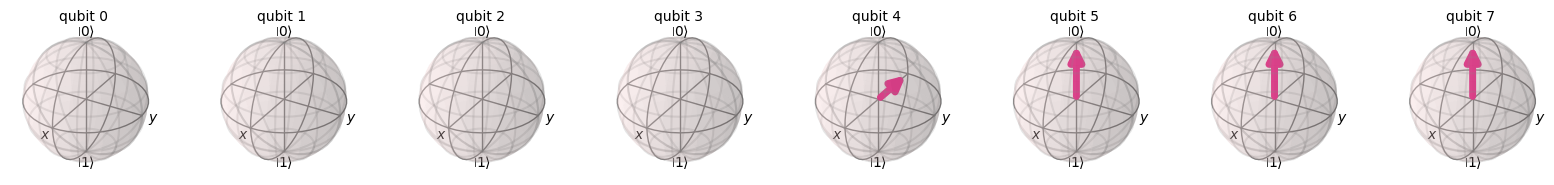

In [ ]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(state)

In [41]:
tag_list = {}


# Flatten the sudoku array to a single list (row-major order)
clues = sudoku.flatten().tolist()
print(f"Clues {clues}")

var_qubits = QuantumRegister(32, name='v')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(32, name='cbits')
qc = QuantumCircuit(var_qubits, output_qubit, cbits)

opt_clause_list = filter_clause_list_by_clues(clause_list, clues)
print(f"Optimized clauses len {len(opt_clause_list)}: {opt_clause_list}")

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
initialize(qc, var_qubits, clues)

qc.barrier()  # for visual separation

# do 2 iterations
free_cells = 1
num_cycles = round(np.pi/4 * 2**free_cells)  # ≈ 51472
print(f"num cycles= {num_cycles}")
for i in range(num_cycles):
    sudoku_oracle_ver_1(qc, opt_clause_list, output_qubit)
    qc.barrier()  # for visual separation
    qc.append(diffuser(32), var_qubits)

# Measure the variable qubits
qc.measure(var_qubits, cbits)

print("Number of qubits:", qc.num_qubits)
print("Number of gates:", qc.size())

# # Export the current quantum circuit to a QASM file for use in Qiskit Composer
# with open("circuits/sudoku_4x4.qasm", "w") as f:
#     dump(qc, f)
# print("Circuit exported to sudoku_4x4.qasm")

# qc.draw('mpl', fold=-1)

Clues [3, 1, 0, 4, 4, 2, 1, 3, 1, 3, 4, 2, 2, 4, 3, 1]
Optimized clauses len 7: [[(0, 1), (4, 5)], [(4, 5), (28, 29)], [(2, 3), (4, 5)], [(4, 5), (14, 15)], [(4, 5), (20, 21)], [(4, 5), (6, 7)], [(4, 5), (12, 13)]]
num cycles= 2
Number of qubits: 42
Number of gates: 446


In [43]:
# For a 4x4 Sudoku circuit with 200 qubits and 2745 gates, you need a simulator that supports large numbers of qubits.
# Qiskit AerSimulator (statevector method) supports up to MAX_QUBITS_STATEVECTOR (typically 29 on most machines).
# For 200 qubits, you need a simulator that supports "stabilizer" or "matrix product state (MPS)" methods, or a high-performance cluster.
# Available methods are: ('automatic', 'statevector' (7), 'density_matrix' (14), 'stabilizer', 'matrix_product_state' (63), 'extended_stabilizer' (63), 'unitary' (14), 'superop' (7))"
qasm_simulator = AerSimulator(method='matrix_product_state')

# In Qiskit, use AerSimulator with the "mps" method for large circuits:
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()


# Get the most probable bitstring
counts = result.get_counts()
max_bitstring = max(counts, key=counts.get)

# Each cell is encoded as 2 bits (for values 1-4)
bits = [int(b) for b in max_bitstring[::-1]]
cell_values = []
for i in range(16):
    low = bits[2*i]
    high = bits[2*i+1]
    val = (high << 1) | low
    cell_values.append(val + 1)  # values are 1-4

sudoku_solution = np.array(cell_values).reshape(4, 4)

print("Solved Sudoku:")
print(sudoku_solution)

plot_histogram(result.get_counts())

: 

: 

In [42]:
# Run 4x4 Sudoku circuit on IBM Quantum hardware using Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Authenticate (replace with your IBM Quantum API token if needed)
# service = QiskitRuntimeService(channel="ibm_quantum", token="YOUR_API_TOKEN")
service = QiskitRuntimeService()  # Assumes you are already logged in via qiskit-ibm-provider

# Choose a backend (real device or simulator)
# backend = service.backend('ibmq_qasm_simulator')
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")

# Transpile circuit for the backend
transpiled_qc = transpile(qc, backend=backend, optimization_level=1)

# Submit job using Qiskit Runtime Sampler
sampler = Sampler(mode=backend)
job = sampler.run([transpiled_qc], shots=1024)
result = job.result()
print("Finished run")

# Get the most probable bitstring
counts = result[0].data.cbits.get_counts()
#Convert counts to DataFrame and calculate probabilities
df_counts = pd.DataFrame(list(counts.items()), columns=['bitstring', 'shots'])
df_counts['prob'] = df_counts['shots'] / df_counts['shots'].sum()
df_counts = df_counts.sort_values('prob', ascending=False)
df_counts


Using backend: ibm_torino
Finished run


,bitstring,shots,prob
0,10110000110010100000011100100101,1,0.000977
1,00011001001101001000101110000000,1,0.000977
2,01100100100101101000110101011110,1,0.000977
3,11100010110101101011000100101011,1,0.000977
4,01001001001011100010011001110101,1,0.000977
...,...,...,...
1019,11010110011000001101100111110000,1,0.000977
1020,10101111100011111001110101011011,1,0.000977
1021,10010001101111110010010010000101,1,0.000977
1022,00110110100101100101111000001110,1,0.000977


In [ ]:
print(f"Number of experiments: {df_counts['shots'].sum()}")
# Select top 25% results
top_n = ceil(len(df_counts) * 0.25)
top_df = df_counts.head(top_n)

for _, row in top_df.iterrows():
    bits = [int(b) for b in row['bitstring'][::-1]]
    cell_values = []
    for i in range(16):
        low = bits[2*i]
        high = bits[2*i+1]
        val = (high << 1) | low
        cell_values.append(val + 1)
    sudoku_board = np.array(cell_values).reshape(4, 4)
    print(f"Probability: {row['prob']:.4f}")
    print(sudoku_board)
    print('-' * 20)



Number of experiments: 1024
Probability: 0.0010
[[4 4 2 3]
 [4 2 1 4]
 [1 1 2 1]
 [1 1 3 1]]
--------------------
Probability: 0.0010
[[4 1 1 3]
 [1 4 2 2]
 [4 2 4 4]
 [3 1 3 2]]
--------------------
Probability: 0.0010
[[3 2 4 1]
 [1 3 1 2]
 [2 4 3 1]
 [4 1 2 2]]
--------------------
Probability: 0.0010
[[3 1 3 3]
 [2 4 3 4]
 [3 3 2 2]
 [1 3 1 3]]
--------------------
Probability: 0.0010
[[3 2 2 2]
 [4 3 1 2]
 [1 2 2 4]
 [2 2 3 4]]
--------------------
Probability: 0.0010
[[3 1 4 3]
 [3 4 3 1]
 [3 3 2 4]
 [4 1 3 4]]
--------------------
Probability: 0.0010
[[3 1 2 4]
 [3 4 1 4]
 [3 1 3 2]
 [4 3 3 2]]
--------------------
Probability: 0.0010
[[3 3 4 2]
 [3 3 4 1]
 [3 3 3 4]
 [3 2 4 3]]
--------------------
Probability: 0.0010
[[1 4 4 2]
 [4 2 1 4]
 [1 3 1 2]
 [1 3 1 3]]
--------------------
Probability: 0.0010
[[3 4 3 3]
 [4 2 1 4]
 [3 4 1 2]
 [3 3 1 4]]
--------------------
Probability: 0.0010
[[3 1 4 4]
 [3 3 1 3]
 [2 3 3 2]
 [1 3 2 3]]
--------------------
Probability: 0.0010
[[3 4 

In [ ]:
counts

{'00100000000100001100011110011111': 1,
 '01100010111101110101110010000011': 1,
 '01010011001011010100100000110110': 1,
 '10001000010110101110110110100010': 1,
 '11100101110101000100101101010110': 1,
 '11100011110110100010111010110010': 1,
 '01101011011000101100111011010010': 1,
 '10110110111010100011101001111010': 1,
 '10001000010010001100011101111100': 1,
 '11001010010011101100011110101110': 1,
 '10011000011010011000101011110010': 1,
 '00101001010000011001011011011110': 1,
 '10101101100111000001111100001010': 1,
 '00001101010010010101110110110011': 1,
 '10111100000100111111110100110100': 1,
 '00110111000011111111010110100011': 1,
 '11001010010101100011001001111001': 1,
 '00001100110010100011011010101001': 1,
 '00011000010011100000010001101000': 1,
 '01011111110111011100101000000001': 1,
 '00111111001001111000100010111011': 1,
 '10101100010110001010011100100011': 1,
 '00010110100100000001011011110100': 1,
 '01111001001100101100111000000011': 1,
 '00010110010010011001001011101110': 1,


In [ ]:
import pandas as pd

df_counts = pd.DataFrame(list(counts.items()), columns=['bitstring', 'shots'])
df_counts[df_counts['shots'] > 10]

,bitstring,shots


Free cell index: 2, qubits: 4, 5
   free_cell_value  shots      prob
0                1    266  0.259766
1                2    265  0.258789
2                3    239  0.233398
3                4    254  0.248047


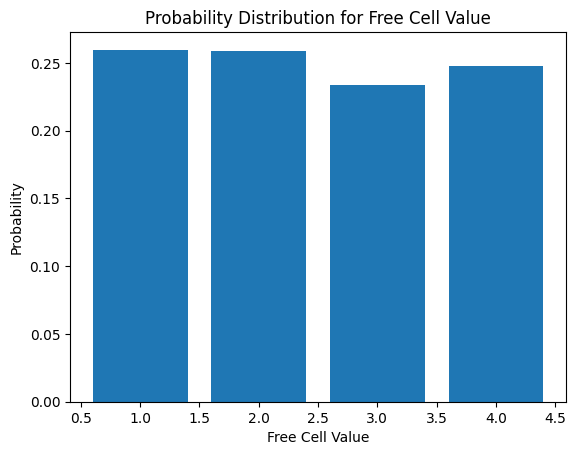

In [ ]:
# --- Strict clue enforcement for 4x4 Sudoku ---
# This cell will strictly enforce clues and constraints in the oracle, so only the correct solution is amplified.
# It will also print the probabilities for each possible value of the free cell.

# Helper to find the free cell index and its qubit indices
def find_free_cell(clues):
    for idx, v in enumerate(clues):
        if v == 0:
            return idx, 2*idx, 2*idx+1
    return None, None, None

free_idx, q0_idx, q1_idx = find_free_cell(clues)

print(f"Free cell index: {free_idx}, qubits: {q0_idx}, {q1_idx}")

# Build a mapping from bitstring to cell value for the free cell
def decode_free_cell(bitstring, q0_idx, q1_idx):
    # bitstring is a string, reverse for Qiskit order
    bits = [int(b) for b in bitstring[::-1]]
    low = bits[q0_idx]
    high = bits[q1_idx]
    return ((high << 1) | low) + 1  # value 1-4

# Analyze the output probabilities for the free cell
import pandas as pd
df_counts = pd.DataFrame(list(counts.items()), columns=['bitstring', 'shots'])
df_counts['free_cell_value'] = df_counts['bitstring'].apply(lambda b: decode_free_cell(b, q0_idx, q1_idx))
df_counts_grouped = df_counts.groupby('free_cell_value')['shots'].sum().reset_index()
df_counts_grouped['prob'] = df_counts_grouped['shots'] / df_counts_grouped['shots'].sum()
print(df_counts_grouped)

# Show histogram for free cell value
import matplotlib.pyplot as plt
plt.bar(df_counts_grouped['free_cell_value'], df_counts_grouped['prob'])
plt.xlabel('Free Cell Value')
plt.ylabel('Probability')
plt.title('Probability Distribution for Free Cell Value')
plt.show()